In [1]:
# import library
import numpy as np 
import pandas as pd
import re
import os

import matplotlib.pyplot as plt
%matplotlib inline

import keras
import keras.utils
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten

from functools import partial
from keras import metrics

In [2]:
MAX_SEQUENCES_LENGTH = 50 # Maximum kata pada kalimat
MAX_NB_WORDS = 6000 # Vocabulary size
EMBEDDING_DIM = 50 # Dimensions of Glove word vector kadang bisa juga 100

In [3]:
# open dataset,save on dataframe
df = pd.read_csv("just_stemming.csv",encoding="ISO-8859-1")

# membuka data slang (data yang akan dibenarkan)
with open('slang.txt') as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2])
    for line in file if line.strip())
    
df.head()

,text,Label
0,itu mah konflik rebut tanah,0
1,karena tidak ada urgensi tidak ada ancam invas...,0
2,ini sah kemarin saya sempat nonton salah satu ...,0
3,analisis yang rumus dari klaster politik luar ...,0
4,bisa tidak palestina taat cara kaffah dalam is...,0


In [4]:
# delete data label netral
df = df[df.Label != 0]

In [5]:
df.loc[df['Label'] == 2, 'Label'] = 0

0    526
1    366
Name: Label, dtype: int64


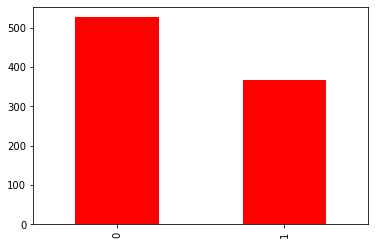

In [6]:
# menghitung Label sentimen (menampilkan tabel pembagian label sentimen)
labels = df.Label
labels_count = labels.value_counts()
labels_count.plot(kind="bar", x='Label', y='Jumlah', color='red')
print(labels.value_counts())

In [7]:
# Prepare to X as Feature
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
sequences = tokenizer.texts_to_sequences(df.text)
# Banyak kata yang telah di tokenizer
word_index = tokenizer.word_index

In [8]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCES_LENGTH)

In [9]:
# Prepare to y as label
y = df["Label"]

In [10]:
classes = ['0', '1']

In [11]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20, stratify=y)

In [ ]:
# open Glove
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join('dataset/glove/vectors.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
# Use GloVe as Word Embedding
hits = 0
misses = 0
index = []
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        index.append(word)

In [ ]:
# Embedding layer with glove
# embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH,weights=[embedding_matrix],trainable=True)

In [12]:
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH)

In [13]:
def create_model():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [14]:
# Train Model
cnn_model = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            125400    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 64)            16064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [15]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
26/26 [==============================] - 14s 25ms/step - loss: 0.6865 - accuracy: 0.5556 - val_loss: 0.6749 - val_accuracy: 0.5889
Epoch 2/40
26/26 [==============================] - 0s 6ms/step - loss: 0.6535 - accuracy: 0.5816 - val_loss: 0.6794 - val_accuracy: 0.6222
Epoch 3/40
26/26 [==============================] - 0s 8ms/step - loss: 0.6317 - accuracy: 0.6769 - val_loss: 0.6890 - val_accuracy: 0.6333
Epoch 4/40
26/26 [==============================] - 0s 6ms/step - loss: 0.6072 - accuracy: 0.6868 - val_loss: 0.7040 - val_accuracy: 0.6222
Epoch 5/40
26/26 [==============================] - 0s 5ms/step - loss: 0.5813 - accuracy: 0.7119 - val_loss: 0.7029 - val_accuracy: 0.6000
Epoch 6/40
26/26 [==============================] - 0s 5ms/step - loss: 0.5291 - accuracy: 0.7409 - val_loss: 0.6930 - val_accuracy: 0.6222
Epoch 7/40
26/26 [==============================] - 0s 5ms/step - loss: 0.4639 - accuracy: 0.8459 - val_loss: 0.6679 - val_accuracy: 0.6222
Epoch 8/40
26/26 [

CNN Accuracy: 0.7555555555555555


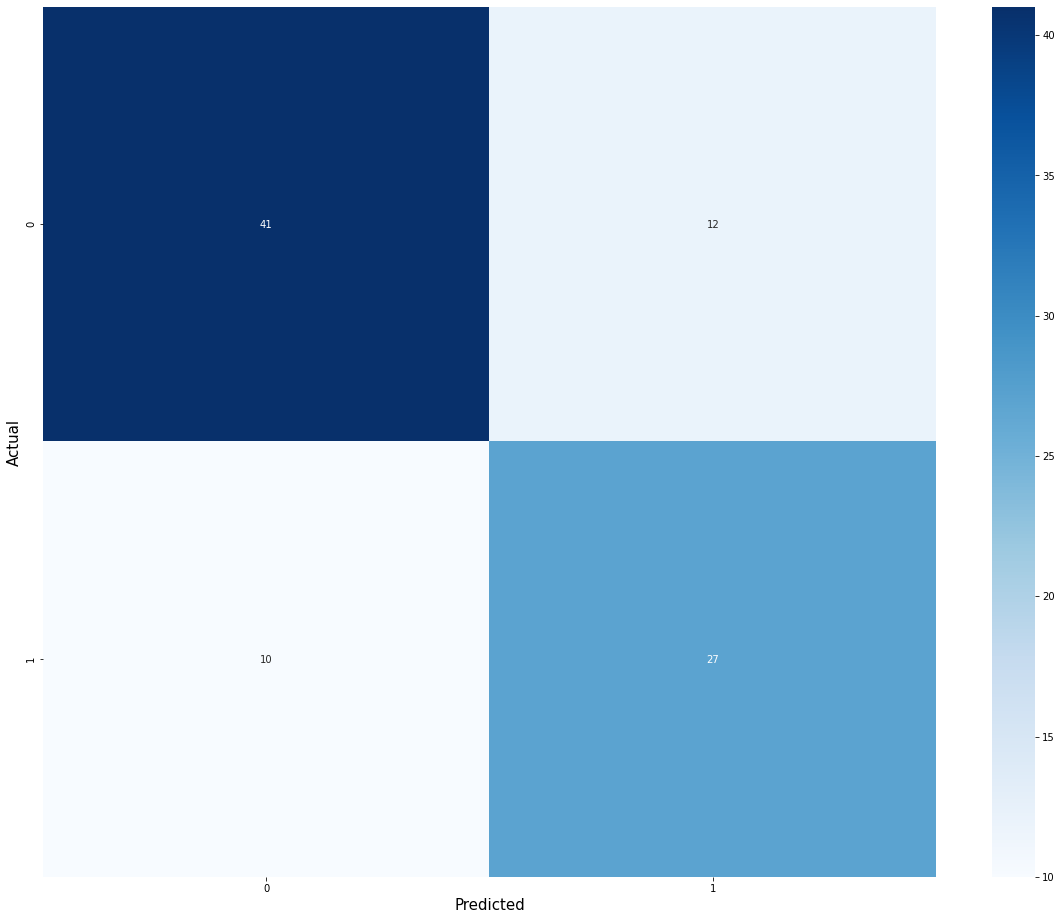

In [16]:
# benerin dulu
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
ypred = cnn_model.predict(X_test)
cnn_accuracy = accuracy_score(y_test,ypred.round())
print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test,ypred.round())
plt.subplots(figsize=(20,16))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cmap="Blues",cbar=True,xticklabels=classes,yticklabels=classes)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
# plt.savefig('model60_e40.png')
plt.show()

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred.round(),target_names= classes))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79        53
           1       0.69      0.73      0.71        37

    accuracy                           0.76        90
   macro avg       0.75      0.75      0.75        90
weighted avg       0.76      0.76      0.76        90



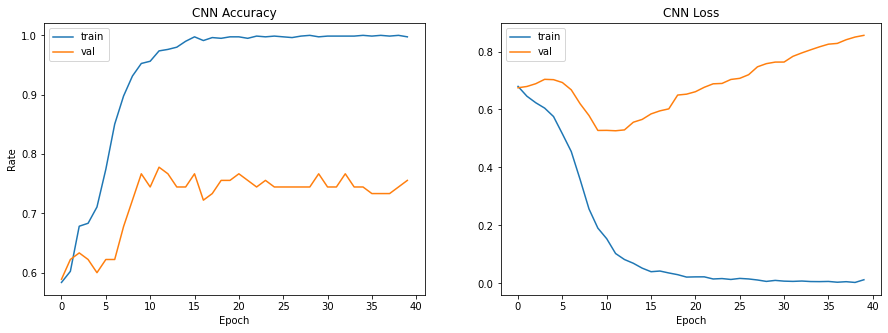

In [18]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(cnn_history.history["accuracy"],label="accuracy")
axe1[0].plot(cnn_history.history["val_accuracy"],label="accuracy")
axe1[0].legend(['train', 'val'], loc='upper left')
axe1[1].plot(cnn_history.history["loss"],label="loss")
axe1[1].plot(cnn_history.history["val_loss"],label="loss")
axe1[1].legend(['train', 'val'], loc='upper left')
axe1[0].title.set_text("CNN Accuracy")
axe1[1].title.set_text("CNN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()